# Knowledge Distillation 

In this notebook we're going to take a pretrained ResNet18 and distill its knowledge to a smaller student network that only has a few layers using CIFAR10 dataset. 

Knowledge distillation was first introduced by Hinton : https://arxiv.org/abs/1503.02531

Knowledge distillation typically usea  temperature parameter (T) to soften the teacher's logits and use that as ground truth to train the student model. The loss is typically a balance of cross entropy of target labels and KL divergence of soft teacher probabilities. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import os 

import time 
import copy

In [2]:
# 1. Transforms for ResNet
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# 2. Load STL10 test set (we'll use test set for evaluation)
train_ds = datasets.STL10(root="./data", split="train", download=True, transform=transform)
test_ds  = datasets.STL10(root="./data", split="test",  download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,  num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=2)

num_labels = 10


In [3]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False  # freeze all layers

model.fc = nn.Linear(model.fc.in_features, num_labels)  # STL10 has 10 classes
model.fc.requires_grad_(True)  # train only the classifier

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

Fine tune the final layer

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=1e-3, momentum=0.9)

model.train()
for epoch in range(5):  
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}")


Epoch 1: Loss = 1.2997
Epoch 2: Loss = 0.4999
Epoch 3: Loss = 0.3705


In [7]:
model.eval()
correct = total = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

print(f"Accuracy on STL10 test set: {correct / total * 100:.2f}%")

torch.save(model.state_dict(), "data/teacher_resnet.pth")

Accuracy on STL10 test set: 92.58%


## Student model

In [9]:
# Load teacher model
teacher = models.resnet18(weights=None)
teacher.fc = nn.Linear(teacher.fc.in_features, 10)
teacher.load_state_dict(torch.load("data/teacher_resnet.pth"))
teacher

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
class DeeperStudentCNN(nn.Module):
    def __init__(self, num_labels=10):
        super(DeeperStudentCNN, self).__init__()
        
        self.conv = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 224 → 112

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112 → 56

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56 → 28

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28 → 14
        )

        self.fc1 = nn.Linear(256 * 14 * 14, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, num_labels)

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


student = DeeperStudentCNN(num_labels)

Use distillation_loss to make student logits have similar probability distribution as the teacher_logits. This is a form of logit based knowledge distillation. In addition we will use cross entropy to blend it in with the KL loss. 

    => F.kl_div(input: log-probabilities, target: probabilities)
    => D_KL(Teacher∥Student)

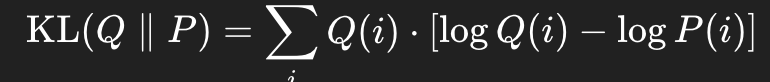
Apparently pytorch drops the log part of target probabilities. 
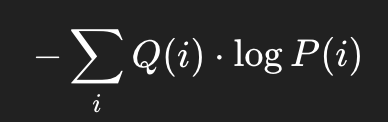

In [12]:
def blended_distillation_loss(student_logits, teacher_logits, labels, T=2.0, alpha=0.7):
    """
    student_logits: output from student model
    teacher_logits: output from teacher model
    labels        : true labels (int)
    T             : temperature
    alpha         : weight for soft loss (teacher)
    """

    # 1. Distillation (soft target) loss: KL divergence between softened distributions
    soft_targets = F.softmax(teacher_logits / T, dim=1)
    student_log_probs = F.log_softmax(student_logits / T, dim=1)
    soft_loss = F.kl_div(student_log_probs, soft_targets, reduction='batchmean') * (T * T) # this was suggested in the paper to restore proper gradients

    # 2. Hard loss: standard cross entropy with ground truth
    hard_loss = F.cross_entropy(student_logits, labels)

    # 3. Weighted combination
    return alpha * soft_loss + (1.0 - alpha) * hard_loss


In [ ]:
# Training
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(student.parameters(), lr=1e-3)
student.train()
for epoch in range(10):
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            teacher_logits = teacher(x)

        student_logits = student(x)
        loss = blended_distillation_loss(student_logits, teacher_logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}")

Epoch 1: Loss = 1.5223
Epoch 2: Loss = 1.2046
Epoch 3: Loss = 0.8855
Epoch 4: Loss = 0.5593
Epoch 5: Loss = 0.4124
Epoch 6: Loss = 0.3457


In [ ]:
model.eval()
correct = total = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        preds = student(x).argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

print(f"Accuracy on STL10 test set: {correct / total * 100:.2f}%")

torch.save(model.state_dict(), "data/sudent_resnet.pth")

In [ ]:
print(f"Accuracy on STL10 test set: {correct / total * 100:.2f}%")


# Feature-based distillation
student is trained to match intermediate representations from the teacher.


In [ ]:
# Feature-based Distillation Loss
def feature_distillation_loss(student_out, teacher_out, student_feat, teacher_feat, labels,
                              alpha=0.7, beta=0.3):
    """
    Combines hard label loss and feature matching loss.
    """
    ce_loss = F.cross_entropy(student_out, labels)
    feat_loss = F.mse_loss(student_feat, teacher_feat.detach())

    return alpha * ce_loss + beta * feat_loss
    
optimizer = torch.optim.Adam(student.parameters(), lr=1e-3)

In [ ]:
# Load teacher
teacher = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
teacher.fc = nn.Linear(teacher.fc.in_features, num_labels)
teacher.load_state_dict(torch.load("data/teacher_resnet.pth"))
teacher.eval()



You typically use hooks to:

    Extract intermediate features (activations)
    Inspect model internals for debugging
    Do feature-based distillation

A little about hook (you can find more info in my quantization notebook):

    - a hook is a function you can "attach" to a module
    - forward hooks to extract intermediate features from the model as it runs


For example let's say: 

    layer = model.layer1[1].relu  # A ReLU inside ResNet block

Then define hook: 

    def hook_fn(module, input, output):
        # Save or inspect output activations
        print(f"Hooked {module.__class__.__name__}, output shape: {output.shape}")
        feature_store["value"] = output

This function will be called everytime. We need somewhere to store the activations:

    feature_store = {}

Now attach the hook:

    handle = layer.register_forward_hook(hook_fn)

Then call it, 

    with torch.no_grad():
        _ = model(input_tensor)
        features = feature_store["value"]

Hooks stay attached until you explicitly remove them:

    handle.remove()



In [ ]:
feature_store = {}

def hook_fn(module, input, output):
    feature_store["feat"] = output

layer = model.layer1[1].relu  # choose your layer
handle = layer.register_forward_hook(hook_fn)

with torch.no_grad():
    _ = model(x)
    feats = feature_store["feat"]

handle.remove()

In [ ]:
# Student
student = DeeperStudentCNN(num_labels=10)

In [ ]:
# Training
student.train()
for epoch in range(5):
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        with torch.no_grad():
            _ = teacher(x)
            f_teacher = teacher_feats["value"]

        s_out, f_student = student(x)
        loss = feature_distillation_loss(s_out, _, f_student, f_teacher, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}")

# Cleanup
handle.remove()
